# NEU-Regression: Simulation Experiments
---

### Functions from the paper:
 - 1) $\min\{\exp(\frac{-1}{(1+x)^2}),x+\cos(x)\}$. Reason: Evaluate performance for pasted functions and general badness.
 - 2) $\cos(\exp(-x))$.  Reason: Evaluate performance for non-periodic osculations.
 - 3) $I_{(-\infty,\frac1{2})}$.  Reason: Evaluation performance on a single jump.  
 
 ---

## Initializations:
- Load Dependancies,
- Makes Paths if missing.

In [14]:
# Load Dependances and makes path(s)
exec(open('Initializations_Dump.py').read())
# Load Hyper( and meta) parameter(s)
exec(open('HyperParameter_Grid.py').read())
# Load Hyper( and meta) parameter(s)
# %run Helper_Functions.ipynb
exec(open('Helper_Functions.py').read())
# Load Models
%run Architecture_Builder.ipynb
# exec(open('Architecture_Builder.py').read())

Complete NEU-Structure Building Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Deep Feature Builder - Ready
Complete NEU-ffNN Training Procedure!!!
Complete NEU-ffNN Training Procedure!!!


# Generate Training Data

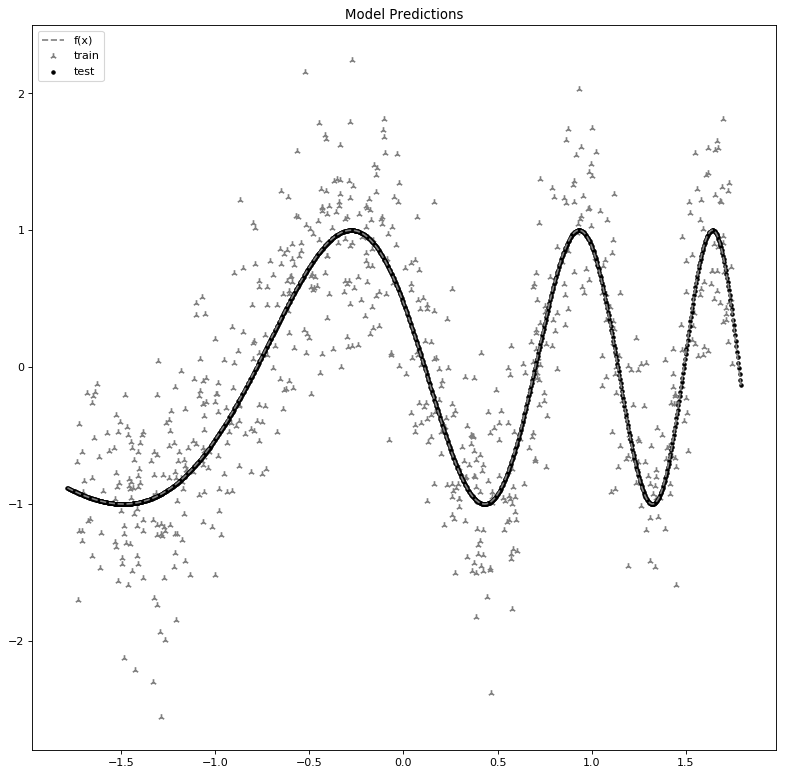

In [2]:
#------------------------#
# Run External Notebooks #
#------------------------#
# Generate Data
Option_Function = "oscilatory"
%run Data_Generator.ipynb

#### Prepare data for NEU

## 1) Get Basic Regression Models
 1. Get Base regression model (benchmark),
 2. Get Base regression model for NEU.

## Get basic regression model - Benchmark

In [9]:
if False:#os.path.exists('./outputs/models/Benchmarks/Linear_Regression/saved_model.pb'):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Benchmark model - already exists: Loading...')
    regression_Benchmark = tf.keras.models.load_model("./outputs/models/Benchmarks/Linear_Regression/")
    print('Benchmark model - already exists: Loaded.')
else:
    print('Pre-trained benchmark model does not exist: Training.')
    tf.random.set_seed(2020)
    ffNN_y_hat_train,ffNN_y_hat_test = build_ffNN(n_folds = CV_folds, 
                                                 n_jobs = n_jobs, 
                                                 n_iter = n_iter, 
                                                 param_grid_in = param_grid_Vanilla_Nets, 
                                                 X_train = data_x, 
                                                 y_train = data_y,
                                                 X_test = data_x_test)

Pre-trained benchmark model does not exist: Training.
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    3.7s finished


Epoch 1/5
94/94 [==============================] - 0s 850us/step - loss: 0.7390 - mse: 0.7708 - mae: 0.7390 - mape: 112.7046
Epoch 2/5
94/94 [==============================] - 0s 921us/step - loss: 0.7199 - mse: 0.7424 - mae: 0.7199 - mape: 114.9087
Epoch 3/5
94/94 [==============================] - 0s 914us/step - loss: 0.7048 - mse: 0.7226 - mae: 0.7048 - mape: 157.6876
Epoch 4/5
94/94 [==============================] - 0s 917us/step - loss: 0.6984 - mse: 0.7198 - mae: 0.6984 - mape: 177.1824
Epoch 5/5
129/129 [==============================] - 0s 1ms/step
Benchmark-Model: Saving
Benchmark-Model: Saved


# Train NEU-OLS

In [12]:
tf.random.set_seed(2020)
# Obtain NEU-OLS predictions and Model
NEU_OLS_y_hat_train_pre, NEU_OLS_y_hat_test_pre, NEU_OLS = build_NEU_OLS(n_folds = CV_folds, 
                                                           n_jobs = n_jobs, 
                                                           n_iter = n_iter, 
                                                           param_grid_in = param_grid_NEU_Feature_Only_Nets, 
                                                           X_train = data_x, 
                                                           y_train = data_y,
                                                           X_test = data_x_test)
# Extract Linearizing Feature Map
Linearizing_Feature_Map = extract_trained_feature_map(NEU_OLS.model)

# Get Linearized Predictions
data_x_featured_train = Linearizing_Feature_Map.predict(data_x)
data_x_featured_test = Linearizing_Feature_Map.predict(data_x_test)

# Coerce data into form ready for NEU-Structure Map
data_x_NEU_train = np.concatenate([data_x_featured_train,NEU_OLS_y_hat_train_pre.reshape(data_x_featured_train.shape[0],D)],axis=1)
data_x_NEU_test = np.concatenate([data_x_featured_test,NEU_OLS_y_hat_test_pre.reshape(data_x_featured_test.shape[0],D)],axis=1)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    6.1s finished


Epoch 1/5
94/94 [==============================] - 0s 2ms/step - loss: 0.7522 - mse: 0.7880 - mae: 0.7502 - mape: 108.5328
Epoch 2/5
94/94 [==============================] - 0s 2ms/step - loss: 0.7418 - mse: 0.7705 - mae: 0.7398 - mape: 113.8208
Epoch 3/5
94/94 [==============================] - 0s 2ms/step - loss: 0.7320 - mse: 0.7548 - mae: 0.7300 - mape: 140.4938
Epoch 4/5
94/94 [==============================] - 0s 2ms/step - loss: 0.7235 - mse: 0.7447 - mae: 0.7216 - mape: 150.3043
Epoch 5/5
129/129 [==============================] - 0s 1ms/step
NEU-OLS: Trained!
NEU-OLS: Saving
NEU-OLS: Saved


In [15]:
NEU_OLS_y_hat_train, NEU_OLS_y_hat_test = build_NEU_Structure(n_folds = CV_folds, 
                                                           n_jobs = n_jobs, 
                                                           n_iter = n_iter, 
                                                           param_grid_in = NEU_Structure_Dictionary, 
                                                           X_train = data_x_NEU_train, 
                                                           y_train = data_y,
                                                           X_test = data_x_NEU_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   10.2s finished


Epoch 1/5
94/94 [==============================] - 0s 3ms/step - loss: 1.6357 - mse: 6.2406 - mae: 1.6041 - mape: 1162.2996
Epoch 2/5
94/94 [==============================] - 0s 3ms/step - loss: 1.4666 - mse: 4.7701 - mae: 1.4443 - mape: 490.4550
Epoch 3/5
94/94 [==============================] - 0s 4ms/step - loss: 1.4462 - mse: 4.7842 - mae: 1.4228 - mape: 638.4209
Epoch 4/5
94/94 [==============================] - 0s 4ms/step - loss: 1.4081 - mse: 4.4853 - mae: 1.3870 - mape: 1121.8109
Epoch 5/5
129/129 [==============================] - 0s 2ms/step
NEU-Structure Map: Trained!
NEU-Structure Map: Saving
NEU-Structure: Saved


# Train NEU-ffNN

In [16]:
tf.random.set_seed(2020)
NEU_ffNN_y_hat_train, NEU_ffNN_y_hat_test = build_NEU_ffNN(n_folds = CV_folds, 
                                                           n_jobs = n_jobs, 
                                                           n_iter = n_iter, 
                                                           param_grid_in = param_grid_NEU_Nets, 
                                                           X_train = data_x, 
                                                           y_train = data_y,
                                                           X_test = data_x_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   10.7s finished


Epoch 1/5
94/94 [==============================] - 0s 3ms/step - loss: 0.7474 - mse: 0.7810 - mae: 0.7454 - mape: 125.1214
Epoch 2/5
94/94 [==============================] - 0s 3ms/step - loss: 0.7341 - mse: 0.7620 - mae: 0.7321 - mape: 121.5719
Epoch 3/5
94/94 [==============================] - 0s 3ms/step - loss: 0.7179 - mse: 0.7365 - mae: 0.7159 - mape: 148.9047
Epoch 4/5
94/94 [==============================] - 0s 3ms/step - loss: 0.7104 - mse: 0.7300 - mae: 0.7084 - mape: 164.1688
Epoch 5/5
129/129 [==============================] - 0s 1ms/step
NEU-ffNN: Trained!
NEU-ffNN: Saving
NEU-ffNN: Saved


---
---
---

# Benchmark Models

Run univariate regression benchmarks file:

In [17]:
# Run Univariate Regression File #
#--------------------------------#
%run Univariate_Regression_Benchmark_Models.ipynb

# Visualize Predictions

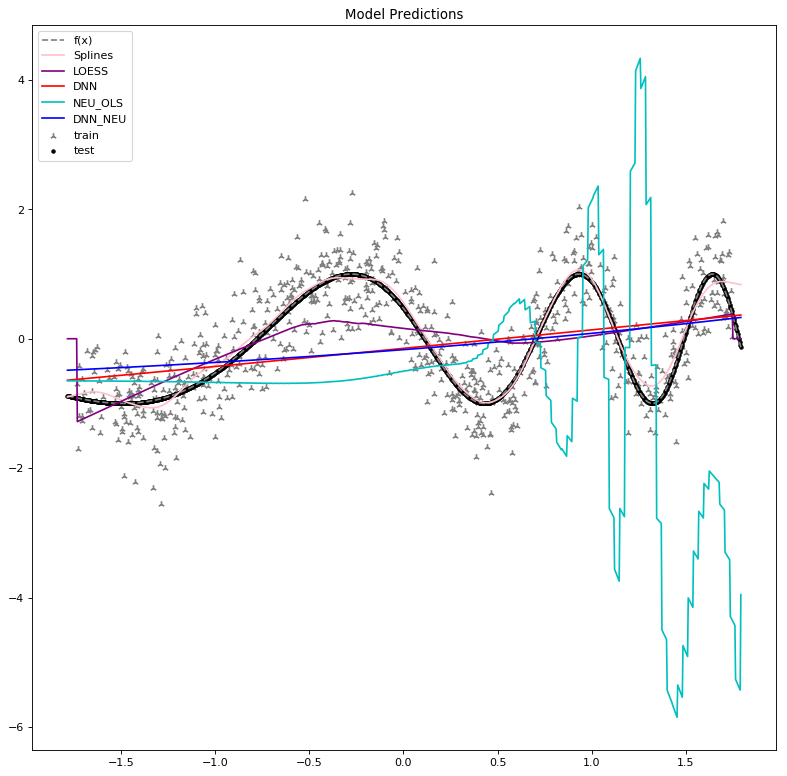

In [18]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

#--------------------#
# Benchmark Model(s) #
#--------------------#
# Plot Non-Linar Benchmark(s): Classical
plt.plot(np.array(data_x_test).reshape(-1,),f_hat_smoothing_splines_test,color='pink',label='Splines')
plt.plot(np.array(data_x_test).reshape(-1,),LOESS_prediction_test,color='purple',label='LOESS')
# Plot Benchmark(s): DNNs
plt.plot(np.array(data_x_test).reshape(-1,),ffNN_y_hat_test, color = 'red', label='DNN')

#--------------#
# NEU-Model(s) #
#--------------#
# Plot NEU-OLS
plt.plot(np.array(data_x_test).reshape(-1,),NEU_OLS_y_hat_test, color = 'c',label='NEU_OLS')
# Plot NEU Regressors
plt.plot(np.array(data_x_test).reshape(-1,),NEU_ffNN_y_hat_test, color = 'blue',label='DNN_NEU')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")
plt.show()

 ---

## Performance Report

In [19]:
#--------------------#
# Classical Model(s) #
#--------------------#
# NEU-OLS Performance
print("NEU-OLS-Performance:")
print(reporter(NEU_OLS_y_hat_train,NEU_OLS_y_hat_test,data_y,data_y_test))


# Splines Performance
print("Splines-Performance:")
print(reporter(f_hat_smoothing_splines_train,f_hat_smoothing_splines_test,data_y,data_y_test))

# Loess Performance
print("LOESS Performance:")
print(reporter(LOESS_prediction_train,LOESS_prediction_test,data_y,data_y_test))

NEU-OLS-Performance:
           train        test
MAE     1.388463    1.360001
MSE     3.734788    3.753198
MAPE  184.257801  186.919849
Splines-Performance:
           train       test
MAE     0.391165   0.085462
MSE     0.235435   0.017128
MAPE  236.221375  32.105315
LOESS Performance:
            train      test
MAE      0.604299  0.467064
MSE      0.551273  0.320436
MAPE  1341.077114       inf


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


In [20]:
#--------------#
# DNN Model(s) #
#--------------#
# ffNN Performance
print("ffNN-Performance:")
print(reporter(ffNN_y_hat_train,ffNN_y_hat_test,data_y,data_y_test))

# NEU-ffNN Performance
print("NEU-ffNN Performance:")
print(reporter(NEU_ffNN_y_hat_train,NEU_ffNN_y_hat_test,data_y,data_y_test))

ffNN-Performance:
           train          test
MAE     0.694144      0.586125
MSE     0.719612      0.464291
MAPE  986.590099  11103.185036
NEU-ffNN Performance:
            train        test
MAE      0.701850    0.604465
MSE      0.728149    0.474991
MAPE  1240.083753  561.334284


#### The END

---